In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering

/home/xux/Desktop/Enzyme_design/Savi_design/Savinase-engineering


# Evaluate pred models

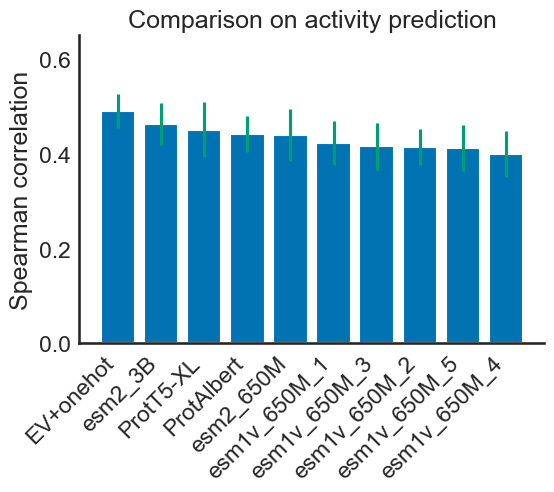

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_style_utils
from ipykernel import kernelapp as app

methods = ['EV+onehot', 'esm2_3B', 'ProtT5-XL', 'ProtAlbert', 'esm2_650M', 'esm1v_650M_1', 'esm1v_650M_3', 'esm1v_650M_2', 'esm1v_650M_5', 'esm1v_650M_4']
spearman = [0.491, 0.463, 0.451, 0.442, 0.440, 0.423, 0.416, 0.415, 0.413, 0.400]
spearman_std = [0.036, 0.045, 0.058, 0.038, 0.054, 0.047, 0.050, 0.038, 0.049, 0.048]
plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.bar(methods, spearman, color=plot_style_utils.CAT_PALETTE[0])
ax.errorbar(methods, spearman, yerr=spearman_std, fmt='none', ecolor=plot_style_utils.CAT_PALETTE[2])
ax.set_title('Comparison on activity prediction')
ax.set_ylabel('Spearman correlation')
ax.set_ylim([0, 0.65])
ax.set_xticks(methods)
ax.set_xticklabels(methods, rotation=45, ha='right')
plot_style_utils.save_for_pub(fig=fig, path='figures/round2/act_pred_model_cmp')

# EV+onehot

In [3]:
import pandas as pd
from popscorer.fitness.ev_onehot import EVOnehotFitness

def load_ev_onehot_predictor(config):
    return EVOnehotFitness(config)

def get_scores(aa_seqs, predictor):
    score, raw_score = predictor(aa_seqs)
    return raw_score

In [4]:
from popgen.utils.utils import parse_config

config = parse_config('notebooks/second_round/config/train_savinase_agent.yaml')

predictor = load_ev_onehot_predictor(config.task.fn_config.activity.ev_onehot)

savinase = 'AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGGASFVPGEPSTQDGNGHGTHVAGTIAALNNSIGVLGVAPSAELYAVKVLGASGSGSVSSIAQGLEWAGNNGMHVANLSLGSPSPSATLEQAVNSATSRGVLVVAASGNSGAGSISYPARYANAMAVGATDQNNNRASFSQYGAGLDIVAPGVNVQSTYPGSTYASLNGTSMATPHVAGAAALVKQKNPSWSNVQIRNHLKNTATSLGSTNLYGSGLVNAEAATR'
wt_score = get_scores([savinase], predictor)[0]

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
2025-09-29 20:54:41.005 | DEBUG    | popscorer.fitness.ev_onehot_pred.predictor:load_model:57 - Ridge regression model loaded from path data/round2/activity/ridge_model.pkl


In [6]:
# load train & test dataset
data_path = 'data/round2/activity'

data_df = pd.read_csv(f'{data_path}/data.csv')
data_df['seq'] = data_df['seq'].str.replace('-', '')
data_df['seq_len'] = data_df['seq'].str.len()
df_data = data_df[data_df.seq_len == 269]
print(data_df.columns)
df_test = pd.read_csv(f'{data_path}/data_test.csv')
print(df_test.columns)

# drop test data from the main dataframe by seq
df_train = data_df[~data_df['seq'].isin(df_test['seq'])]
print(df_train.columns)
print(len(data_df), len(df_test), len(df_train), )

df_train['pred_fitness'] = get_scores(df_train.seq, predictor)
df_test['pred_fitness'] = get_scores(df_test.seq, predictor)

print(df_train.pred_fitness.min(), df_train.pred_fitness.max(), df_test.pred_fitness.min(), df_test.pred_fitness.max())

Index(['seq', 'log_fitness', 'mean_act', 'seq_len'], dtype='object')
Index(['Unnamed: 0.1', 'Unnamed: 0', 'seq', 'log_fitness', 'mean_act'], dtype='object')
Index(['seq', 'log_fitness', 'mean_act', 'seq_len'], dtype='object')
2405 481 1918


/tmp/ipykernel_2485658/942500970.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['pred_fitness'] = get_scores(df_train.seq, predictor)


-5.0 1.0017484666436502 -3.434541616799275 1.4797944415510627


Train fit: 0.522x + 0.092
Test Spearman's rho: 0.596, p=0.000


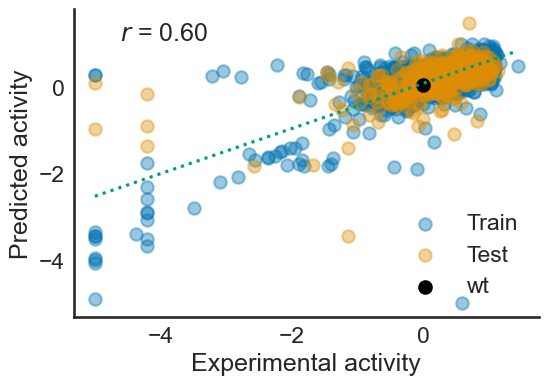

In [7]:
import numpy as np
from utils import plot_style_utils
from scipy import stats

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.scatter(df_train.log_fitness, df_train.pred_fitness, alpha=0.4, label='Train', color=plot_style_utils.CAT_PALETTE[0])
ax.scatter(df_test.log_fitness, df_test.pred_fitness, alpha=0.4, label='Test', color=plot_style_utils.CAT_PALETTE[1])
ax.scatter([0.0], [wt_score], alpha=1.0, label='wt', color='black')

train_fit = np.polyfit(df_train.log_fitness, df_train.pred_fitness, 1)
x = np.sort(df_train.log_fitness)
ax.plot(x, train_fit[0] * x + train_fit[1], linestyle=':', color=plot_style_utils.CAT_PALETTE[2])
print(f"Train fit: {train_fit[0]:.3f}x + {train_fit[1]:.3f}")

spearman = stats.spearmanr(df_test.log_fitness, df_test.pred_fitness)

print(f"Test Spearman's rho: {spearman[0]:.3f}, p={spearman[1]:.3f}")
ax.text(0.1, 0.9, "$\it{r}$"+f" = {spearman[0]:.2f}", transform=ax.transAxes)
# ax.axhline(y=wt_score, color='r', linestyle='--')

ax.set_xlabel('Experimental activity')
ax.set_ylabel('Predicted activity')
ax.legend(loc='lower right', frameon=False)

plot_style_utils.save_for_pub(fig=fig, path='figures/round2/act_model')

# pLM models

In [8]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def load_embeddings(config, backbone_model='ProtAlbert'):
    df_data = pd.read_csv(os.path.join(config.data_dir, 'data.csv'))
    embedding_dir = os.path.join(config.data_dir, backbone_model)
    embd_file = os.path.join(embedding_dir, backbone_model + '.npy')

    if os.path.exists(embd_file):
        prot_embd = np.load(embd_file)
    else:
        # Process ESM embeddings
        esm_embd = []

        for id in range(len(df_data['seq'])):
            emb = torch.load(os.path.join(embedding_dir, f'seq_{id}.pt'))['mean_representations'][33] if backbone_model != 'esm2_t36_3B_UR50D' else torch.load(os.path.join(embedding_dir, f'seq_{id}.pt'))['mean_representations'][36]
            esm_embd.append(emb)
        prot_embd = torch.stack(esm_embd, dim=0).numpy()
        np.save(embd_file, prot_embd)

    Xs = prot_embd
    Ys = df_data['log_fitness'].values
    indices = np.arange(len(Xs))

    Xs_train, Xs_test, ys_train, ys_test, indices_train, indices_test = train_test_split(Xs, Ys, indices, train_size=config.train_size)
    df_train = df_data.iloc[indices_train].copy()
    df_test = df_data.iloc[indices_test].copy()
    return Xs_train, Xs_test, df_train, df_test

In [10]:
from utils.utils import parse_config, set_random_seed
import pickle
from scipy.stats import spearmanr

def load_models(model_dir, head_model_type='svm'):
    pca_model = pickle.load(open(f'{model_dir}/pca_model.pkl', 'rb'))
    head_model = pickle.load(open(f'{model_dir}/head_model_{head_model_type}.pkl', 'rb'))
    return pca_model, head_model

def transform_pred(embeddings, pca_model, head_model):
    pca_embeddings = pca_model.transform(embeddings)
    pred = head_model.predict(pca_embeddings)
    return pred

# ! pip install scikit-learn==1.3.0

def pred_plm_fitness(data_config, model_config):
    set_random_seed(model_config.seed)
    Xs_train, Xs_test, df_train, df_test = load_embeddings(data_config, model_config.backbone_model)

    pca_model, head_model = load_models(model_config.model_dir, head_model_type=model_config.head_model)
    df_train['pred_fitness'] = transform_pred(Xs_train, pca_model, head_model)
    df_test['pred_fitness'] = transform_pred(Xs_test, pca_model, head_model)

    return df_train, df_test

In [11]:
config_path = 'notebooks/second_round/config/predictor_plm_config.yaml'

config = parse_config(config_path)

In [16]:
import os
import numpy as np
from utils import plot_style_utils
from scipy import stats

def plot_plm_scatter_plot(df_train, df_test, wt_score=-0.099922, prop='activity', model_id='plm1', ref='wt'):
    plot_style_utils.set_pub_plot_context(context="talk")
    fig, ax = plot_style_utils.simple_ax()
    plot_style_utils.prettify_ax(ax)

    ax.scatter(df_train.log_fitness, df_train.pred_fitness, alpha=0.4, label='Train', color=plot_style_utils.CAT_PALETTE[0])
    ax.scatter(df_test.log_fitness, df_test.pred_fitness, alpha=0.4, label='Test', color=plot_style_utils.CAT_PALETTE[1])
    ax.scatter([0.0], [wt_score], alpha=1.0, label=ref, color='black')

    train_fit = np.polyfit(df_train.log_fitness, df_train.pred_fitness, 1)
    x = np.sort(df_train.log_fitness)
    ax.plot(x, train_fit[0] * x + train_fit[1], linestyle=':', color=plot_style_utils.CAT_PALETTE[2])
    print(f"Train fit: {train_fit[0]:.3f}x + {train_fit[1]:.3f}")

    spearman = stats.spearmanr(df_test.log_fitness, df_test.pred_fitness)

    print(f"Test Spearman's rho: {spearman[0]:.3f}, p={spearman[1]:.3f}")
    ax.text(0.1, 0.9, "$\it{r}$"+f" = {spearman[0]:.2f}", transform=ax.transAxes)
    # ax.axhline(y=wt_score, color='r', linestyle='--')

    ax.set_xlabel(f'Experimental {prop}')
    ax.set_ylabel(f'Predicted {prop}')
    ax.legend(loc='lower right', frameon=False)
    os.makedirs(f'figures/round2/plm_models', exist_ok=True)

    plot_style_utils.save_for_pub(fig=fig, path=f'figures/round2/plm_models/eval_{prop}_model_{model_id}')

## Model 1 ESM_3B

In [17]:
df_train, df_test = pred_plm_fitness(config.activity.data, config.activity.model1)

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
savinase = 'AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGGASFVPGEPSTQDGNGHGTHVAGTIAALNNSIGVLGVAPSAELYAVKVLGASGSGSVSSIAQGLEWAGNNGMHVANLSLGSPSPSATLEQAVNSATSRGVLVVAASGNSGAGSISYPARYANAMAVGATDQNNNRASFSQYGAGLDIVAPGVNVQSTYPGSTYASLNGTSMATPHVAGAAALVKQKNPSWSNVQIRNHLKNTATSLGSTNLYGSGLVNAEAATR'

display(df_train[df_train['seq'] == savinase])
display(df_test[df_test['seq'] == savinase])

,seq,log_fitness,mean_act,pred_fitness
1818,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,0.0,1.0,0.37788


,seq,log_fitness,mean_act,pred_fitness


Train fit: 0.194x + 0.170
Test Spearman's rho: 0.512, p=0.000


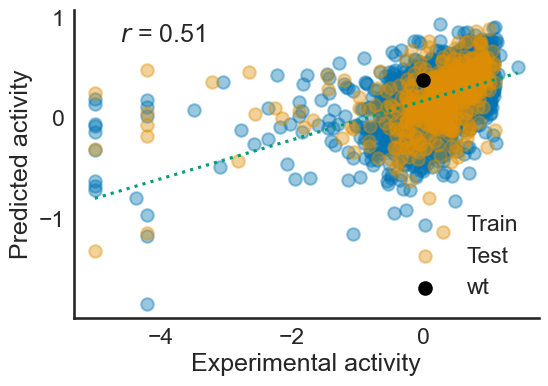

In [19]:
plot_plm_scatter_plot(df_train, df_test, wt_score=0.377866, prop='activity', model_id='plm1')

## Model 2: ProtT5-XL

In [20]:
df_train, df_test = pred_plm_fitness(config.activity.data, config.activity.model2)

display(df_train[df_train['seq'] == savinase])
display(df_test[df_test['seq'] == savinase])

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,seq,log_fitness,mean_act,pred_fitness
1818,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,0.0,1.0,0.356803


,seq,log_fitness,mean_act,pred_fitness


Train fit: 0.271x + 0.159
Test Spearman's rho: 0.517, p=0.000


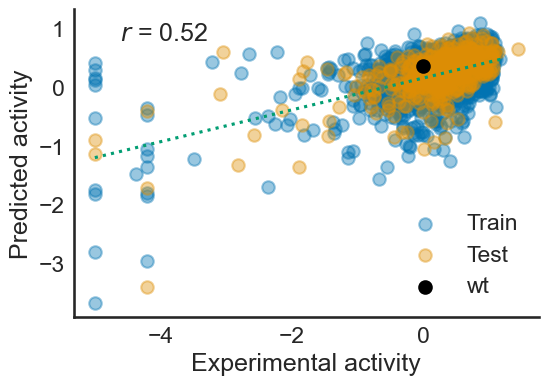

In [21]:
plot_plm_scatter_plot(df_train, df_test, wt_score=0.356803, prop='activity', model_id='plm2')

## Model 3: ProtAlbert

In [22]:
df_train, df_test = pred_plm_fitness(config.activity.data, config.activity.model3)

display(df_train[df_train['seq'] == savinase])
display(df_test[df_test['seq'] == savinase])

/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/xux/miniconda3/envs/prot-gen-env/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 1.3.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,seq,log_fitness,mean_act,pred_fitness
1818,AQSVPWGISRVQAPAAHNRGLTGSGVKVAVLDTGISTHPDLNIRGG...,0.0,1.0,0.235405


,seq,log_fitness,mean_act,pred_fitness


Train fit: 0.214x + 0.181
Test Spearman's rho: 0.485, p=0.000


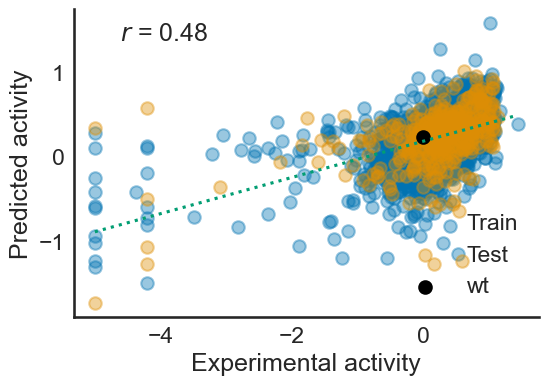

In [23]:
plot_plm_scatter_plot(df_train, df_test, wt_score=0.235405, prop='activity', model_id='plm3')